# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import tensorflow.keras.backend as K
layers = keras.layers
tf.compat.v1.disable_eager_execution()  # gp loss won't work with eager
from functools import partial
from NuRadioReco.utilities import fft
from NuRadioReco.utilities import units
from NuRadioReco.framework import base_trace
import sys

In [2]:
sys.path.insert(1, '/lustre/fs22/group/radio/dhjelm/')
import data_preprocessing

# Data

## Load data from file and shuffle 

In [3]:
dataset = np.load('/lustre/fs22/group/radio/dhjelm/data.npy')
np.random.shuffle(dataset)

## Preprocess data

In [33]:
# RMS
rms = data_preprocessing.rms_preprocessing(dataset)

# L1
l1 = data_preprocessing.l1_preprocessing(rms)

# Remove DC-offset
fft_traces = fft.time2freq(l1, 3.2*units.GHz)
# no_offset = fft_traces[:,1:len(fft_traces[0])]
fft_traces[:,0] = 0
data_no_offset = fft.freq2time(fft_traces, 3.2*units.GHz)

# Shorten the trace
short = data_no_offset[:,0:512]
# short = data_no_offset

# Normalization
normalize = data_preprocessing.normalize(short)

# Set data to the normailzed data
data = normalize

# Calculate trace length
trace_length = len(data[0])

## Train on FFT data

In [5]:
# data = abs(fft.time2freq(data, 3.2*units.GHz))
# trace_length = len(data[0])

## Plot a couple of traces to check that everything looks okey

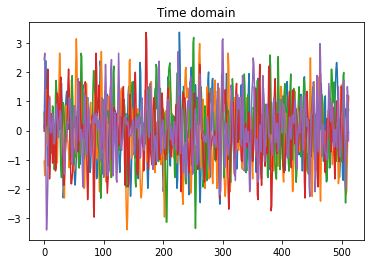

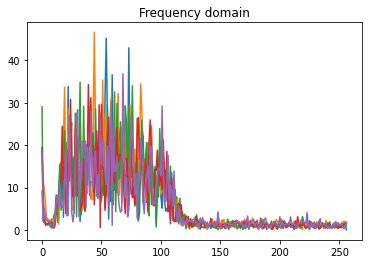

In [34]:
for i in range(5):
    plt.plot(data[i])
plt.title("Time domain")
plt.show()

for i in range(5):
    plt.plot(abs(fft.time2freq(data[i], 3.2*units.GHz)))
plt.title("Frequency domain")
plt.show()


# GAN implementation

## Generator

In [37]:
# Generator architecture
def generator_model(latent_size):
    """ Generator network """
    
    # Arguments used for the layers
    kwargs = {'kernel_size': 9, 'padding': 'same', 'kernel_initializer': 'he_normal'}
    
    noise = layers.Input(shape=(latent_size,1), name = "noise")
    
    x = layers.Dense(latent_size)(noise)
    
    x = layers.Conv1D(filters=latent_size/4, **kwargs)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv1DTranspose(filters=latent_size/8, strides=2, **kwargs)(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv1D(filters=latent_size/8, **kwargs)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv1DTranspose(filters=latent_size/16, strides=2, **kwargs)(x)
    x = layers.LeakyReLU()(x)
    
    
#     x = layers.Conv1D(filters=latent_size/16, **kwargs)(x)
#     x = layers.LeakyReLU()(x)
#     x = layers.Conv1DTranspose(filters=latent_size/32, strides=2, **kwargs)(x)
#     x = layers.LeakyReLU()(x)
    
#     x = layers.Conv1D(filters=latent_size/16, **kwargs)(x)
#     x = layers.ReLU()(x)
#     x = layers.Conv1DTranspose(filters=latent_size/32, strides=2, **kwargs)(x)
#     x = layers.ReLU()(x)
    
    
    
    x = layers.Conv1D(filters=latent_size/16, **kwargs)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv1D(filters=1, **kwargs)(x)
    
    generator = keras.models.Model(noise, x, name="generator")
    return generator

    
    

In [38]:
# Create the generator

# Latent size
latent_size = 128

# Number of filter
n_filters=32

g = generator_model(latent_size)
g.summary()
# keras.utils.plot_model(g, show_shapes=True)

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
noise (InputLayer)           [(None, 128, 1)]          0         
_________________________________________________________________
dense_10 (Dense)             (None, 128, 128)          256       
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 128, 32)           36896     
_________________________________________________________________
leaky_re_lu_44 (LeakyReLU)   (None, 128, 32)           0         
_________________________________________________________________
conv1d_transpose_11 (Conv1DT (None, 256, 16)           4624      
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   (None, 256, 16)           0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 256, 16)           23

## Critic (Discriminator)

In [39]:
# Critic architecture
def critic_model(trace_length, n_filter =8):
    """ Critic network """
    
    kwargs = {'padding':'same', 'kernel_initializer':'he_normal', 'strides':4}
    
    # Create signal input layer 
    signal_input = layers.Input(shape=(trace_length, 1), name = "signal_input")
    
    # Create Conv1D and LeakyRelu layers with different kernel sizes
    x1 = layers.Conv1D(filters=n_filters, kernel_size=1, **kwargs)(signal_input)
    x1 = layers.LeakyReLU()(x1)
    
    x2 = layers.Conv1D(filters=n_filters, kernel_size=2, **kwargs)(signal_input)
    x2 = layers.LeakyReLU()(x2)
    
    x3 = layers.Conv1D(filters=n_filters, kernel_size=4, **kwargs)(signal_input)
    x3 = layers.LeakyReLU()(x3)
    
    x4 = layers.Conv1D(filters=n_filters, kernel_size=8, **kwargs)(signal_input)
    x4 = layers.LeakyReLU()(x4)
    
    x5 = layers.Conv1D(filters=n_filters, kernel_size=16, **kwargs)(signal_input)
    x5 = layers.LeakyReLU()(x5)
    
    x6 = layers.Conv1D(filters=n_filters, kernel_size=32, **kwargs)(signal_input)
    x6 = layers.LeakyReLU()(x6)

    # Concatenate all layers
    x = tf.concat((x1, x2, x3, x4, x5, x6), axis=2)
    
    # Send concatenated layers into Conv1D
    x = layers.Conv1D(filters=1, kernel_size=1, padding='same',
                      kernel_initializer='he_normal')(x)
    
    x = layers.LeakyReLU()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dense(32)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dense(1)(x)
    

    critic = keras.models.Model(signal_input, x,name="critic")
    
    return critic

In [40]:
# Create the critic
n_filters = 8
critic = critic_model(trace_length, n_filters)
critic.summary()

Model: "critic"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
signal_input (InputLayer)       [(None, 512, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_37 (Conv1D)              (None, 128, 8)       16          signal_input[0][0]               
__________________________________________________________________________________________________
conv1d_38 (Conv1D)              (None, 128, 8)       24          signal_input[0][0]               
__________________________________________________________________________________________________
conv1d_39 (Conv1D)              (None, 128, 8)       40          signal_input[0][0]               
_____________________________________________________________________________________________

## Training pipelines

Pipelines between the networks to be able to construct and train the GAN

In [41]:
def make_trainable(model, trainable):
    ''' Freezes/unfreezes the weights in the given model '''
    for layer in model.layers:

        if type(layer) is layers.BatchNormalization:
            layer.trainable = True
        else:
            layer.trainable = trainable

In [42]:
# Freeze the critic during the generator training and unfreeze the generator during the generator training
make_trainable(critic, False) 
make_trainable(g, True)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
noise (InputLayer)           [(None, 128, 1)]          0         
_________________________________________________________________
generator (Functional)       (None, 512, 1)            45913     
_________________________________________________________________
critic (Functional)          (None, 1)                 10970     
Total params: 56,883
Trainable params: 45,913
Non-trainable params: 10,970
_________________________________________________________________


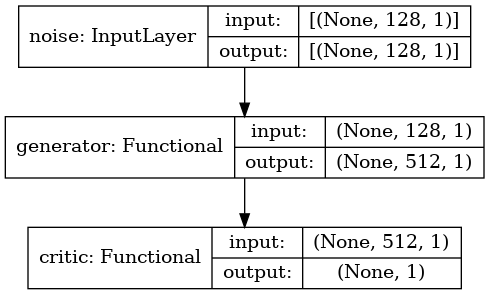

In [43]:
# Stack the generator o top of the critic and finiliaze the training pipeline of the generator
gen_input = g.inputs
generator_training = keras.models.Model(gen_input, critic(g(gen_input)))
generator_training.summary()
keras.utils.plot_model(generator_training, show_shapes=True)

# Wasserstein loss

In [44]:
def wasserstein_loss(y_true, y_pred):
    """Calculates the Wasserstein loss - critic maximises the distance between its output for real and generated samples.
    To achieve this generated samples have the label -1 and real samples the label 1. Multiplying the outputs by the labels results to the wasserstein loss via the Kantorovich-Rubinstein duality"""
    return K.mean(y_true * y_pred)

# Compile generator for training using the Wasserstein loss as loss function
generator_training.compile(keras.optimizers.Adam(
    0.0001, beta_1=0.5, beta_2=0.9, decay=0.0), loss=[wasserstein_loss])


## Gradient penalty

To obtain the Wasserstein distance, we have to use the gradient penalty to enforce the Lipschitz constraint.
Therefore, we need to design a layer that samples on straight lines between reals and fakes samples 

In [45]:
# Size of the batches used in training
BATCH_SIZE = 64

class UniformLineSampler(tf.keras.layers.Layer):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size

    def call(self, inputs, **kwargs):
        weights = K.random_uniform((self.batch_size, 1, 1))
        return(weights * inputs[0]) + ((1 - weights) * inputs[1])

    def compute_output_shape(self, input_shape):
        return input_shape[0]

In [46]:
make_trainable(critic, True)  # unfreeze the critic during the critic training
make_trainable(g, False)  # freeze the generator during the critic training

g_out = g(g.inputs)
critic_out_fake_samples = critic(g_out, n_filters)
critic_out_data_samples = critic(critic.inputs)
averaged_batch = UniformLineSampler(BATCH_SIZE)([g_out, critic.inputs[0]])
averaged_batch_out = critic(averaged_batch)
critic_training = keras.models.Model(inputs=[g.inputs, critic.inputs], outputs=[critic_out_fake_samples, critic_out_data_samples, averaged_batch_out])

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
noise (InputLayer)              [(None, 128, 1)]     0                                            
__________________________________________________________________________________________________
generator (Functional)          (None, 512, 1)       45913       noise[0][0]                      
__________________________________________________________________________________________________
signal_input (InputLayer)       [(None, 512, 1)]     0                                            
__________________________________________________________________________________________________
uniform_line_sampler_1 (Uniform (64, 512, 1)         0           generator[1][0]                  
                                                                 signal_input[0][0]         

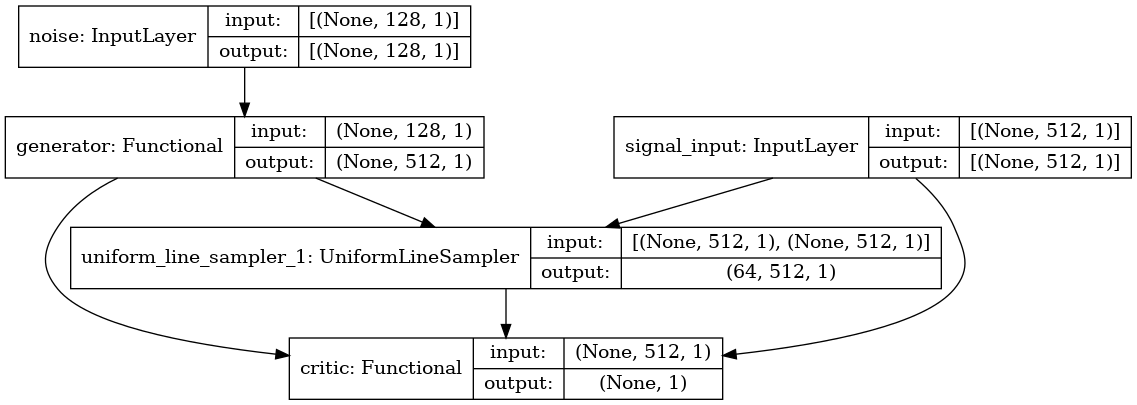

In [47]:
critic_training.summary()
keras.utils.plot_model(critic_training, show_shapes=True)

### Gradient penalty loss

In [48]:
def gradient_penalty_loss(y_true, y_pred, averaged_batch, penalty_weight):
    """Calculates the gradient penalty.
    The 1-Lipschitz constraint of improved WGANs is enforced by adding a term that penalizes a gradient norm in the critic unequal to 1."""
    
    # Gradients
    gradients = K.gradients(y_pred, averaged_batch)[0]
    
    # Gradients sqruared
    gradients_sqr = K.square(gradients)
    
    # Sum over the rows
    gradients_sqr_sum = K.sum(gradients_sqr, axis=np.arange(1, len(gradients_sqr.shape)))
    
    # Sqrt
    gradient_l2_norm =  K.sqrt(gradients_sqr_sum) 
                              
    # Compute penalty_weight * (1 - ||grad||)^2 still for each single sample                        
    gradient_penalty = penalty_weight * K.square(1 - gradient_l2_norm)
    
    return K.mean(gradient_penalty)

# Construct the gradient penalty
gradient_penalty_weight = 5
gradient_penalty = partial(gradient_penalty_loss, averaged_batch=averaged_batch, penalty_weight=gradient_penalty_weight)  
gradient_penalty.__name__ = 'gradient_penalty'

In [49]:
# Compile critic
critic_training.compile(keras.optimizers.Adam(0.00005, beta_1=0.5, beta_2=0.9, decay=0.0), loss=[wasserstein_loss, wasserstein_loss, gradient_penalty])

In [50]:
# Keras throws an error when calculating a loss without having a label -> needed for using the gradient penalty loss
positive_y = np.ones(BATCH_SIZE)
negative_y = -positive_y
dummy = np.zeros(BATCH_SIZE) 


# Training

In [51]:
# Create arrays for generator and critic loss
generator_loss = []
critic_loss = []

In [54]:
# Training parameters
EPOCHS = 50
nsamples = len(data)
critic_iterations = 5
iterations_per_epoch = nsamples*2//(BATCH_SIZE*critic_iterations)
iters = 0
print(iterations_per_epoch)

65


Epoch:  0
Iteration 1
Critic loss: [0.11114502, 4.2985716, -4.221271, 0.033844594]
Generator loss: -4.0674553


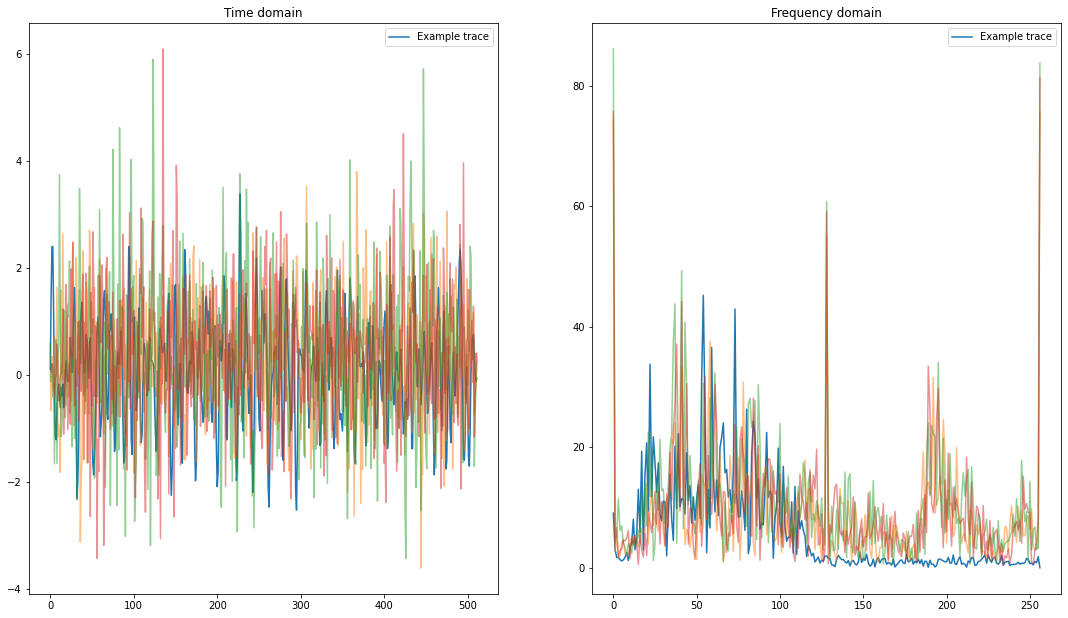

Epoch:  1
Epoch:  2


KeyboardInterrupt: 

In [55]:

for epoch in range(EPOCHS):
    
    print("Epoch: ", epoch)

    for iteration in range(iterations_per_epoch):
#         print(iteration)
       
        for j in range(critic_iterations):
            
            # Pick data in batches 
            bunch=data[BATCH_SIZE*(j+iteration):BATCH_SIZE*(j++iteration+1)]
            bunch = np.expand_dims(bunch, axis=-1)  

            # Generate noise
            noise_batch = np.random.randn(BATCH_SIZE, latent_size)
            noise_batch = np.expand_dims(noise_batch, axis=-1) 
            
#             print(f"Data batch: {np.shape(bunch)}")
#             print(f"Noise batch: {np.shape(noise_batch)}")
       
            
            # Train critic
            critic_loss.append(critic_training.train_on_batch([noise_batch, bunch], [negative_y, positive_y, dummy]))
        

        # Generate noise batch for generator
        noise_batch = np.random.randn(BATCH_SIZE, latent_size)
        noise_batch = np.expand_dims(noise_batch, axis=-1) 
        
        # Train the generator
        generator_loss.append(generator_training.train_on_batch([noise_batch], [positive_y]))  
        iters+=1
        
        # Printing errors and plotting example traces
        if iters % 300 == 1:
            print("Iteration", iters)
            print("Critic loss:", critic_loss[-1])
            print("Generator loss:", generator_loss[-1])
            
            # Generate signals
            noise = np.random.randn(BATCH_SIZE, latent_size)
            noise = np.expand_dims(noise, axis=-1) 
            generated_signals = g.predict_on_batch(noise)
            generated_signals = generated_signals[:,:,0]
#             print(np.shape(generated_signals[0]))
#             print(len(abs(fft.time2freq(generated_signals[0], 3.2*units.GHz))))
            
            
            # Plot data
            
            fig, (ax1, ax2) = plt.subplots(1, 2)
            fig.set_size_inches(18.5, 10.5, forward=True)
            ax1.title.set_text('Time domain')
            ax2.title.set_text('Frequency domain')
            
            

            ax1.plot(data[0], label = "Example trace")
#             plt.plot(np.random.randn(trace_length), label = 'Random noise')
            for i in range(3):
                ax1.plot(generated_signals[i], alpha=0.5)
            
            
            # Plot frequency
            ax2.plot(abs(fft.time2freq(data[0], 3.2*units.GHz)), label = "Example trace")
            for i in range(3):
                ax2.plot(abs(fft.time2freq(generated_signals[i], 3.2*units.GHz)),alpha=0.5)
                
            ax1.legend()
            ax2.legend()
            plt.show()



        
       

        #generated_signal = g.predict_on_batch(np.random.randn(BATCH_SIZE, latent_size))
    
    #print("Critic loss:", critic_loss[-1])
    #print("Generator loss:", generator_loss[-1])


## Loss functions

Text(0, 0.5, 'Loss')

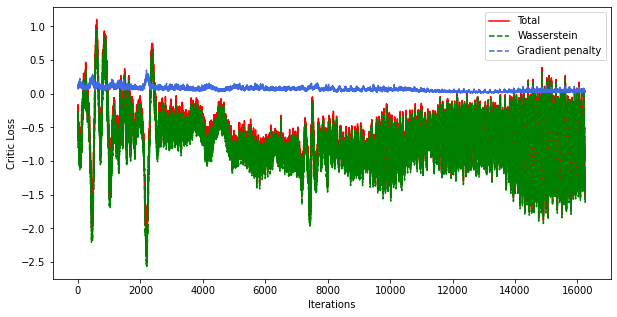

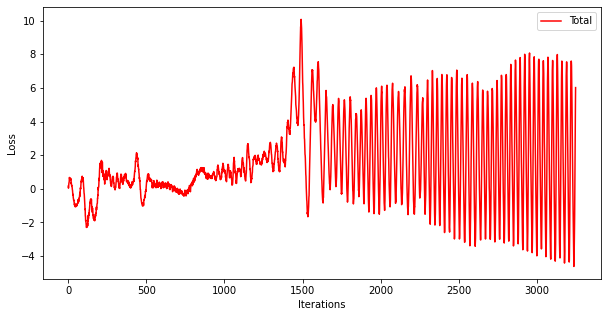

In [24]:
critic_loss = np.array(critic_loss)
plt.subplots(1, figsize=(10, 5))
plt.plot(np.arange(len(critic_loss)), critic_loss[:,0], color='red', markersize=12, label=r'Total')
plt.plot(np.arange(len(critic_loss)), critic_loss[:,1] + critic_loss[:, 2], color='green', label=r'Wasserstein', linestyle='dashed')
plt.plot(np.arange(len(critic_loss)), critic_loss[:, 3], color='royalblue', markersize=12, label=r'Gradient penalty', linestyle='dashed')
plt.legend(loc='upper right')
plt.xlabel(r'Iterations')
plt.ylabel(r'Critic Loss')
#plt.ylim(-6, 3)

generator_loss = np.array(generator_loss)

plt.subplots(1, figsize=(10, 5))
plt.plot(np.arange(len(generator_loss)), generator_loss, color='red', markersize=12, label=r'Total')
plt.legend(loc='upper right')
plt.xlabel(r'Iterations')
plt.ylabel(r'Loss')


# #save the generated networks
# g.save('generator')
# critic.save('critic')

# Analyzing the results

In [25]:
noise = np.random.randn(BATCH_SIZE, latent_size)
noise = np.expand_dims(noise, axis=-1) 
generated_signals = g.predict_on_batch(noise)

## Time domain

In [26]:
print(f"Mean generated: {np.mean(generated_signals)}")
print(f"Mean data: {np.mean(data)}\n")

print(f"Std generated: {np.std(generated_signals)}")
print(f"Std data: {np.std(data)}\n")

Mean generated: 0.08331611007452011
Mean data: -3.9703973544379164e-18

Std generated: 0.9995554685592651
Std data: 0.9999999999999996



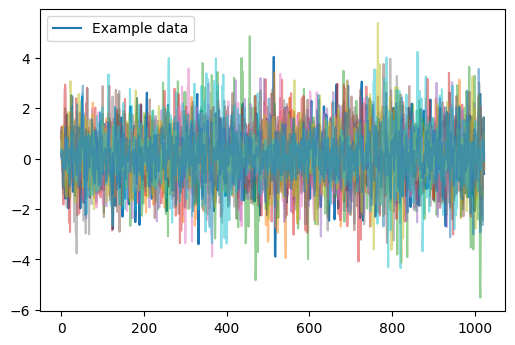

In [27]:
plt.rcParams["figure.dpi"]= 100

plt.plot(data[0], label = "Example data")
for i in range(10):
    plt.plot(generated_signals[5*i],alpha=0.5)
# plt.plot(np.random.randn(trace_length), label = 'Random noise')
plt.legend()


## Frequency domain

10444


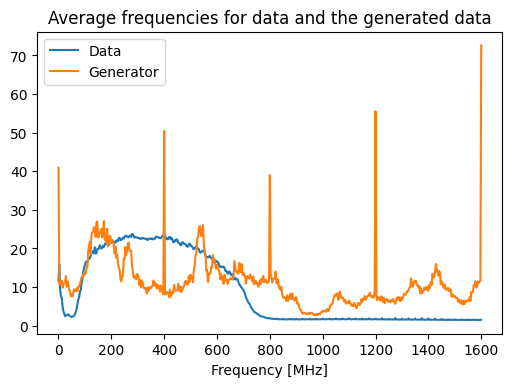

In [28]:
# Get frequencies of data
data_freq = fft.time2freq(data, 3.2*units.GHz)

print(nsamples)
# Get frequencies of generated data
noise = np.random.randn(BATCH_SIZE, latent_size)
noise = np.expand_dims(noise, axis=-1) 
generated_signals = g.predict_on_batch(noise)
generated_signals = generated_signals[:,:,0]

generator_freq = fft.time2freq(generated_signals, 3.2*units.GHz)

# Get average frequencies for both
avg_freq_data = np.mean(abs(data_freq), axis=0)
avg_freq_generator = np.mean(abs(generator_freq), axis=0)



# Create dummy trace to get frequencies
dummy_trace = base_trace.BaseTrace()
dummy_trace.set_trace(np.zeros(trace_length), sampling_rate = 3.2*units.GHz)

plt.plot(dummy_trace.get_frequencies()/units.MHz,avg_freq_data, label =f"Data")
plt.plot(dummy_trace.get_frequencies()/units.MHz,avg_freq_generator, label =f"Generator")
plt.xlabel("Frequency [MHz]")
# plt.ylabel("Square root of power per MHZ")
plt.title("Average frequencies for data and the generated data")
plt.legend()

#plt.semilogy()




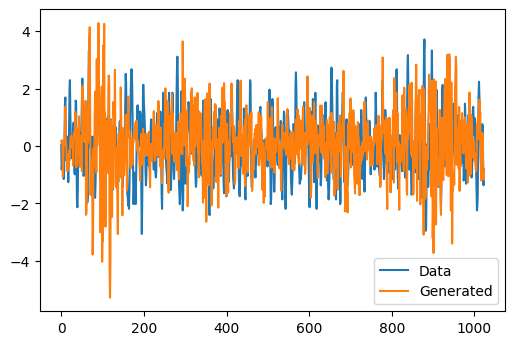

In [29]:
plt.plot(data[1], label ="Data")
plt.plot(generated_signals[1], label = "Generated")
plt.legend()